# LSTM-CNN Model With GloVe

In [1]:
import os
import re
import shutil
import string

import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('cleaned_df.csv')

df

,Unnamed: 0.1,Unnamed: 0,tweet,Label,clean_tweet,clean_tweet2
0,0,90896,"Th blizzards R landing all over th ceiling, wa...",Sex Trafficking,blizzards landing all over ceiling walls and f...,blizzards landing ceiling walls floor country ...
1,1,47283,@LALewman What the dimwits fail to acknowledge...,Rape,what the dimwits fail acknowledge that ectopic...,dimwits fail acknowledge ectopic pregnancy kil...
2,2,33330,Good to know that @bbcnews @bbcworldservice do...,Rape,good know that not care about the rape women a...,good know not care rape women girls not russia...
3,3,48737,S/O to all of you who want Roe V Wade overturn...,Rape,all you who want roe wade overturned and who g...,want roe wade overturned guess providing finan...
4,4,92382,@Mr_Macaaroni Sex worker industry fuels human ...,Sex Trafficking,sex worker industry fuels human trafficking th...,sex worker industry fuels human trafficking ca...
...,...,...,...,...,...,...
85692,85692,91446,Sex trafficking is bad for the economy!!!!,Sex Trafficking,sex trafficking bad for the economy,sex trafficking bad economy
85693,85693,74923,@bassie_hd @MAJDAL774632662 @lion_4_zion @AD_G...,Sexual Harassment,seems that your mind intellectually polluted a...,seems mind intellectually polluted carries not...
85694,85694,4357,@Redlizzieredd @todd_spader Domestic Violence ...,Domestic Violence,domestic violence needs outlet they should gym...,domestic violence needs outlet gym feeling str...
85695,85695,41500,@Steevec10 @theJagmeetSingh It's 9 months out ...,Rape,months out her entire life you should not murd...,months entire life not murder baby someone els...


Find Maximum Sentences

In [3]:
df['Num_words_text'] = df['clean_tweet2'].apply(lambda x:len(str(x).split())) 
mask = df['Num_words_text'] >2
df = df[mask]
max_dataset_sentence_length  = df['Num_words_text'].max()
print('Dataset Max Sentence Length :'+str(max_dataset_sentence_length))

Dataset Max Sentence Length :42


Find Number of Words

In [4]:
from nltk.tokenize import word_tokenize
import nltk

def create_corpus_tk(my_df):
    corpus = []
    for text in my_df["clean_tweet2"]:
        words = [word.lower() for word in word_tokenize(text)]
        corpus.append(words)
    return corpus

In [5]:
corpus = create_corpus_tk(df)

num_words = len(corpus)
print(num_words)

83914


## Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

X = df['clean_tweet2']
Y = pd.get_dummies(df['Label']).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42) #shuffle = False)

## Tokenization

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 50

In [8]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [9]:
train_sequences = tokenizer.texts_to_sequences(X_train)

In [10]:
train_padded = pad_sequences(
    train_sequences, maxlen=max_len, truncating="post", padding="post"
)

In [11]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_len, truncating="post", padding="post"
)

In [12]:
word_index = tokenizer.word_index
print("Number of unique words: ", len(word_index))

Number of unique words:  48798


## Create Embedding Dictionary

In [14]:
embedding_dict = {}
f = open("../GloVe/GloVe_Twitter/glove.twitter.27B.100d.txt", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], "float32")
    embedding_dict[word] = vectors
f.close()

In [15]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [16]:
print(train_padded.shape)
print(Y_train.shape)

(67131, 50)
(67131, 8)


In [17]:
print(test_padded.shape)
print(Y_test.shape)

(16783, 50)
(16783, 8)


## LSTM-CNN With GloVe Model

In [18]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, LSTM
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(
    Embedding(
        num_words,
        100,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_len,
        trainable=False,
    )
)

model.add(LSTM(100, return_sequences=True,name='lstm_layer'))  #, dropout=0.1
model.add(Conv1D(100, 4, activation='relu')) # dropout=0.1
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100,activation="relu"))
model.add(Dense(8,activation="softmax"))

optimizer = Adam(learning_rate=3e-4)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           4879900   
                                                                 
 lstm_layer (LSTM)           (None, 50, 100)           80400     
                                                                 
 conv1d (Conv1D)             (None, 47, 100)           40100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 100)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2300)              0         
                                                                 
 dense (Dense)               (None, 100)               230100    
                                                      

In [19]:
%%time

history = model.fit(
    train_padded,
    Y_train,
    epochs=20,
    validation_split=0.1,
    #validation_data=(test_padded, Y_test),
    verbose=1,
)

Epoch 1/20
1889/1889 [==============================] - 126s 65ms/step - loss: 0.0582 - accuracy: 0.9141 - val_loss: 0.0267 - val_accuracy: 0.9607
Epoch 2/20
1889/1889 [==============================] - 102s 54ms/step - loss: 0.0201 - accuracy: 0.9710 - val_loss: 0.0178 - val_accuracy: 0.9762
Epoch 3/20
1889/1889 [==============================] - 113s 60ms/step - loss: 0.0149 - accuracy: 0.9782 - val_loss: 0.0151 - val_accuracy: 0.9780
Epoch 4/20
1889/1889 [==============================] - 104s 55ms/step - loss: 0.0121 - accuracy: 0.9815 - val_loss: 0.0136 - val_accuracy: 0.9809
Epoch 5/20
1889/1889 [==============================] - 102s 54ms/step - loss: 0.0106 - accuracy: 0.9838 - val_loss: 0.0143 - val_accuracy: 0.9797
Epoch 6/20
1889/1889 [==============================] - 91s 48ms/step - loss: 0.0090 - accuracy: 0.9865 - val_loss: 0.0145 - val_accuracy: 0.9789
Epoch 7/20
1889/1889 [==============================] - 96s 51ms/step - loss: 0.0080 - accuracy: 0.9877 - val_loss: 0.0

## Save Model

In [20]:
from tensorflow import keras

model.save('hybrid_model1')
model = keras.models.load_model('hybrid_model1')

INFO:tensorflow:Assets written to: hybrid_model1\assets


INFO:tensorflow:Assets written to: hybrid_model1\assets


In [21]:
import json

with open('hybrid_history1.json', 'w') as f:
    json.dump(history.history, f)

In [1]:
import json

f = open('hybrid_history1.json')
history = json.load(f)

In [ ]:
history??

## Evaluation

In [23]:
accr = model.evaluate(test_padded,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

525/525 [==============================] - 14s 26ms/step - loss: 0.0274 - accuracy: 0.9808
Test set
  Loss: 0.027
  Accuracy: 0.981


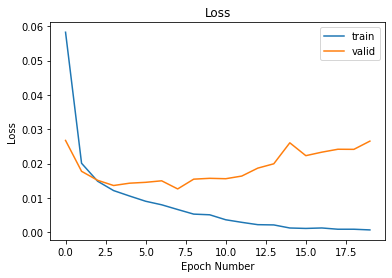

In [2]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()
plt.show();

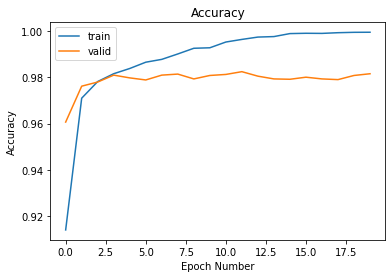

In [3]:
plt.title('Accuracy')
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='valid')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [26]:
sequences = tokenizer.texts_to_sequences(X_test)
padded_y = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

In [27]:
pred_y = model.predict(padded_y)
pred_y_int = pred_y.round().astype("int")

In [28]:
import matplotlib.pyplot as plt

def plot_value_array(i, predictions_array, true_label):
  labels = [0,1,2,3,4,5,6,7] #['Domestic Violence', 'Rape', 'Sexual Harassment', 'Sex Trafficking', 'Forced Marriage', 
          #'Online Violence', 'femicide', 'forced abortion']
  true_label = true_label
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  vector = np.vectorize(np.float64)
  h = vector(predictions_array.reshape(1, -1))
  thisplot = plt.bar(range(8), h[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = labels[np.argmax(predictions_array.reshape(1, -1))]

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

men emotions men experience abuse domestic violence men able express feelings report abuse vocal praying every man going thru something silently
Domestic Violence 100% (Domestic Violence)


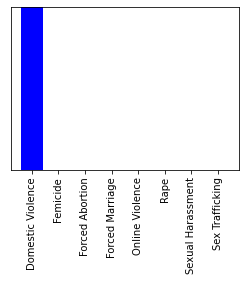

In [29]:
#print(pred, labels[np.argmax(pred)])

i = 5000
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

my_word = decode(sequences[i])
print(my_word)
new_data = [my_word]
seq = tokenizer.texts_to_sequences(new_data)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = [0,1,2,3,4,5,6,7] 
label = labels[np.argmax(Y_test[i])]
class_names = ['Domestic Violence', 'Femicide', 'Forced Abortion', 'Forced Marriage',
               'Online Violence', 'Rape', 'Sexual Harassment', 'Sex Trafficking']

print("{} {:2.0f}% ({})".format(class_names[labels[np.argmax(pred)]],
                                100*np.max(pred),
                                class_names[label]))

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plot_value_array(i, pred,  label)
_ = plt.xticks(range(8), class_names, rotation=90)
plt.show()

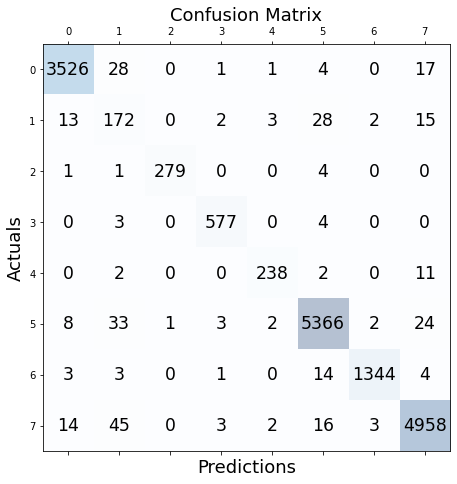

In [30]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
#
y_pred = []
test_label = []
for i in range(len(pred_y)):
    vector = np.vectorize(np.float64)
    predY = vector(pred_y[i])
    y_pred.append(np.argmax(predY))
    test_label.append(np.argmax(Y_test[i]))

conf_matrix = confusion_matrix(y_true=test_label, y_pred=y_pred) #, labels=class_names
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(Y_test.argmax(axis=1),pred_y.argmax(axis=1)))
print(classification_report(Y_test.argmax(axis=1),pred_y.argmax(axis=1),target_names=class_names))
print(accuracy_score(Y_test.argmax(axis=1),pred_y.argmax(axis=1)))

[[3526   28    0    1    1    4    0   17]
 [  13  172    0    2    3   28    2   15]
 [   1    1  279    0    0    4    0    0]
 [   0    3    0  577    0    4    0    0]
 [   0    2    0    0  238    2    0   11]
 [   8   33    1    3    2 5366    2   24]
 [   3    3    0    1    0   14 1344    4]
 [  14   45    0    3    2   16    3 4958]]
                   precision    recall  f1-score   support

Domestic Violence       0.99      0.99      0.99      3577
         Femicide       0.60      0.73      0.66       235
  Forced Abortion       1.00      0.98      0.99       285
  Forced Marriage       0.98      0.99      0.99       584
  Online Violence       0.97      0.94      0.95       253
             Rape       0.99      0.99      0.99      5439
Sexual Harassment       0.99      0.98      0.99      1369
  Sex Trafficking       0.99      0.98      0.98      5041

         accuracy                           0.98     16783
        macro avg       0.94      0.95      0.94     16783
    